# Pipeline using Tsfresh and Adapt
Creation of the pipeline for the classical ML model

In [1]:
%matplotlib inline

import tsfresh
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.metrics import classification_report
from adapt.feature_based import FA

import pandas as pd
from my_package.add_columns import create_time_column, create_rul_columns
from my_package.utils import create_df, plot_data, return_df, roll_data

from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

import numpy as np
# Necessary to due to skopt not being up-to-date
np.int = int

## Load Data
Loading Training-Data, Test-Data and Validation-Data

In [8]:
#TODO: Files angeben
dir_data = '../data.nosync/'

#Folder Names
data_s_train = ['train/Bearing1_1', 'train/Bearing1_2', 'train/Bearing2_1']
data_s_test = ['test/Bearing1_3', 'test/Bearing1_4', 'test/Bearing1_5', 'test/Bearing1_6', 'test/Bearing1_7']
data_s_validate = ['validate/Bearing1_3']
data_t_train = ['train/Bearing3_1', 'train/Bearing3_2']
data_t_test = []
data_t_validate = []

#Creation of df based on folder names
df_s_train = return_df(dir_data, data_s_train)
df_s_test = return_df(dir_data, data_s_test)
#df_s_validate = return_df(dir_data, data_s_validate)
df_t_train = return_df(dir_data, data_t_train)
#df_t_test = return_df(dir_data, data_t_test)
#df_t_validate = return_df(dir_data, data_t_validate)

## Plot Data

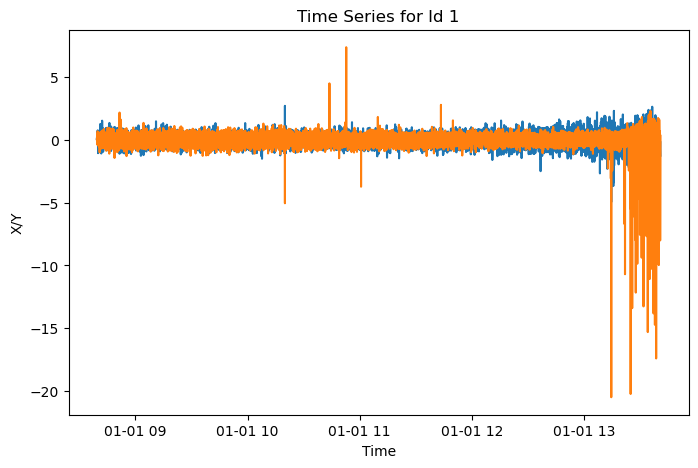

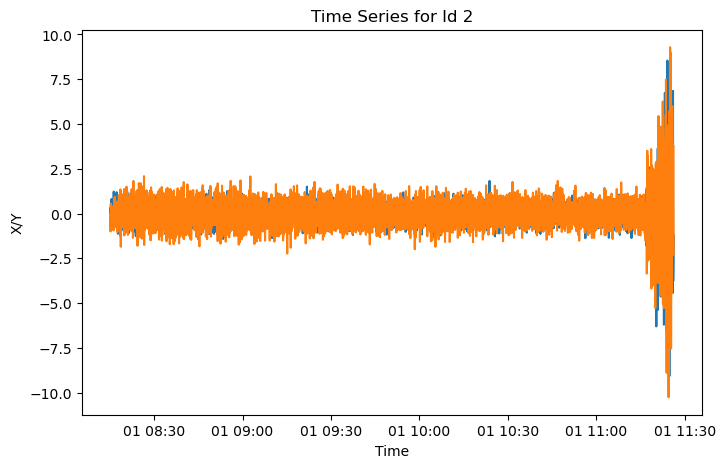

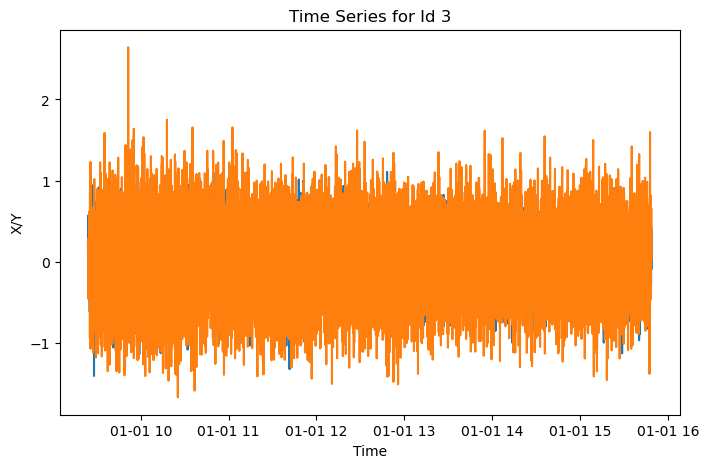

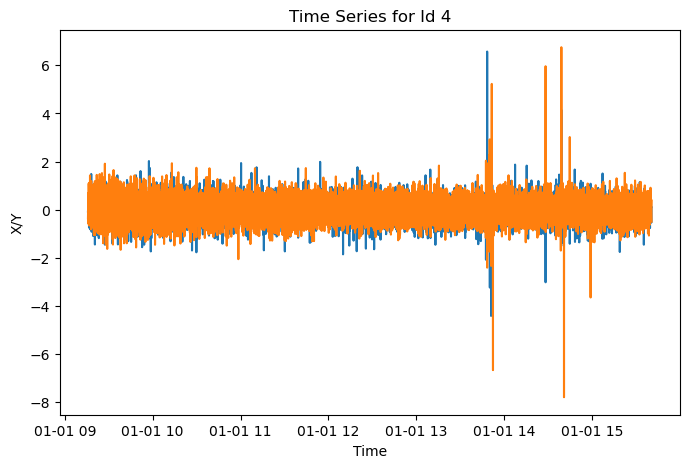

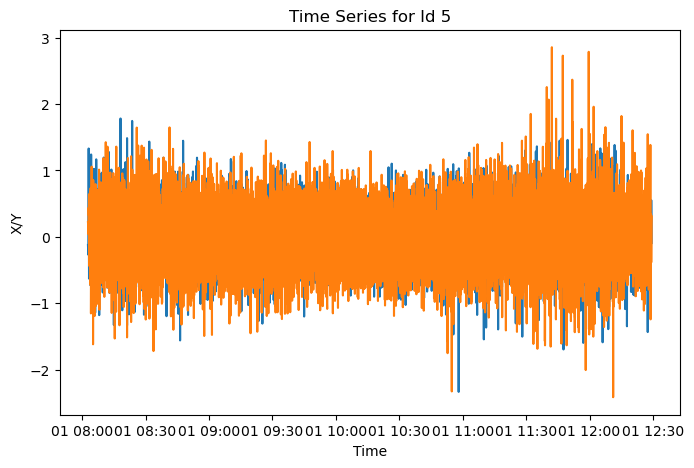

In [10]:
plot_data(df_s_test)

## Roll Data

In [11]:
#TODO: Params festlegen
df_s_train_rolled = roll_data(df_s_train, min_timeshift=1000, rolling_direction=2000)
df_s_test_rolled = roll_data(df_s_test, min_timeshift=1000, rolling_direction=2000)
df_t_train_rolled = roll_data(df_t_train, min_timeshift=1000, rolling_direction=2000)

/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 9/9 [00:01<00:00,  4.87it/s]
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


## Feature Generation

In [12]:
# TODO: Params festlegen
X_s_train = extract_features(df_s_train_rolled.drop(columns=["RUL_cat", 'time_end', 'bearing_id', 'RUL', 'roll_RUL', 'value_RUL']), column_id='id', column_sort='time', default_fc_parameters= tsfresh.feature_extraction.MinimalFCParameters(), impute_function=impute)

Feature Extraction: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


## Feature Selection

In [16]:
y_s_train = df_s_train_rolled['roll_RUL']
y_s_test = df_s_test_rolled['roll_RUL']
y_t_train=df_t_train_rolled['roll_RUL']
y_s_train.index = df_s_train_rolled['id'].tolist()
y_s_test.index = df_s_test_rolled['id'].tolist()
y_t_train.index = df_t_train_rolled['id'].tolist()
y_s_train_distinct = y_s_train.groupby(level=0).last()
y_s_test_distinct = y_s_test.groupby(level=0).last()
y_t_train_distinct = y_t_train.groupby(level=0).last()

In [14]:
#TODO: fdr_level festlegen
X_s_train_selected = select_features(X_s_train, y_s_train_distinct, ml_task='classification', show_warnings=True, fdr_level= 0.4)

/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/feature_selection/relevance.py:337: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  table_binary["p_value"] = pd.Series(
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/feature_selection/relevance.py:337: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  table_binary["p_value"] = pd.Series(
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/feature_selection/relevance.py:337: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  table_binary["p_value"] = pd.Series(
/Users/felixschreyer/anaconda3/envs/Testing/lib/p

In [15]:
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(X_s_train_selected)
X_t_train_selected = extract_features(df_t_train_rolled.drop(columns=["RUL_cat", 'time_end', 'bearing_id', 'RUL', 'roll_RUL', 'value_RUL']), column_id='id', column_sort='time', kind_to_fc_parameters= kind_to_fc_parameters,impute_function=impute)
X_s_test_selected = extract_features(df_s_test_rolled.drop(columns=["RUL_cat", 'time_end', 'bearing_id', 'RUL', 'roll_RUL', 'value_RUL']), column_id='id', column_sort='time', kind_to_fc_parameters= kind_to_fc_parameters,impute_function=impute)

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


## Data Processing

In [23]:
Xs_train = X_s_train_selected
Xs_test = X_s_test_selected
Xt_train = X_t_train_selected
ys_train = y_s_train_distinct
ys_test = y_s_test_distinct
yt_train = y_t_train_distinct

## Parameter Optimization

In [24]:
forest_clf = RandomForestClassifier()

search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(1, 20), # values of max_depth are integers from 1 to 20
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(50, 900)
    }

forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=50, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, #cv=2
                                    )

forest_bayes_search.fit(Xs_test, ys_test) # callback=on_step will print score after each iteration

/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/sklearn/model_selection/_split.

BayesSearchCV(estimator=RandomForestClassifier(), n_jobs=-1, scoring='accuracy',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=900, prior='uniform', transform='normalize')})

In [25]:
forest_bayes_search.best_score_

0.4333333333333333

## Training

In [26]:
model = FA(forest_bayes_search.best_estimator_, Xt=Xt_train[:-6], yt=yt_train[:-6], random_state=0)

In [30]:
forest_bayes_search.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'fit_params': None,
 'iid': 'deprecated',
 'n_iter': 50,
 'n_jobs': -1,
 'n_points': 1,
 'optimizer_kwargs': None,
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'search_spaces': {'bootstrap': Categorical(categories=(True, False), prior=

In [28]:
model.fit(Xs_train, ys_train)


model.score(Xt_train, yt_train)
print(classification_report(yt_train, model.predict(Xt_train)))

Fit transform...
Previous shape: (16, 9)
New shape: (18, 27)
Fit Estimator...
              precision    recall  f1-score   support

         -10       0.00      0.00      0.00         1
          -6       0.00      0.00      0.00         1
          -3       0.00      0.00      0.00         1
           0       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           4       0.12      1.00      0.22         1

    accuracy                           0.12         8
   macro avg       0.02      0.17      0.04         8
weighted avg       0.02      0.12      0.03         8


/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
X_t_train_selected

In [ ]:
y_t_train_distinct

In [29]:
model.score(Xs_train, ys_train)

0.5